In [65]:
from sdv.demo import load_timeseries_demo
import pandas as pd

In [66]:
data = pd.read_csv('./AAPL Historical Data.csv')
data['Date'] =pd.to_datetime(data.Date)
data = data.sort_values(by='Date')
data.to_csv('new.csv')

In [67]:
data.head()

,Date,Price
0,2013-11-01,19.86
1,2013-12-01,20.04
2,2014-01-01,17.88
3,2014-02-01,18.79
4,2014-03-01,19.17


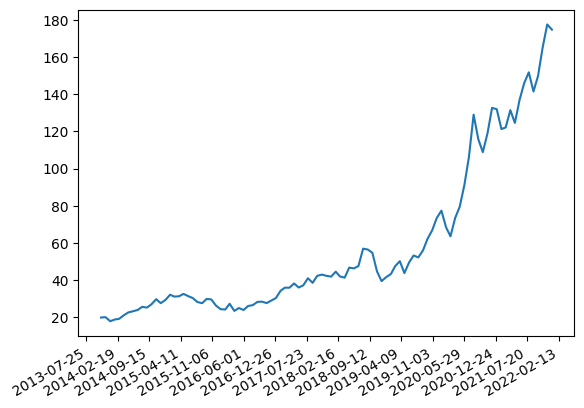

In [74]:
import matplotlib as plt
data = pd.read_csv('new.csv')
dates = list(data['Date'])
import datetime as dt
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = list(data['Price'])

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 5000))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.show()

In [75]:
from sdv.timeseries import PAR


In [76]:
sequence_index = 'Symbol'

In [77]:
context_columns = ['Price']

In [78]:
model = PAR( 
     entity_columns= ['Date']
  )

In [79]:
model.fit(data)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/deepecho/sequences.py:181: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, sequence in data.groupby(entity_columns):


In [80]:
data_new = model.sample(1)

In [81]:
data_new = pd.DataFrame(data_new)

In [82]:
data_new['Date'] =pd.to_datetime(data_new.Date)
data_new = data_new.sort_values(by='Date')
data_new.to_csv('new.csv')

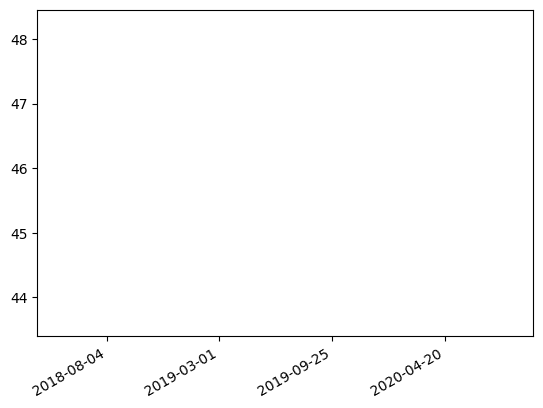

In [83]:
import matplotlib as plt
data_new = pd.read_csv('new.csv')
dates = list(data_new['Date'])
import datetime as dt
x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]
y = list(data_new['Price'])

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 5000))
plt.plot(x,y)
plt.gcf().autofmt_xdate()
plt.show()